<a href="https://colab.research.google.com/github/nveenkumr/HMM_POS_Tagger/blob/main/Gesture_Recognition_Naveen_Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition 
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

In [3]:
!pip install gdown
import gdown
url = "https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
output = "Project_data.zip"
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/Project_data.zip
1.71GB [00:10, 158MB/s] 


'Project_data.zip'

In [4]:
#unzip the download folder 
import shutil
shutil.unpack_archive("Project_data.zip" , "Project_data")

In [30]:
#Let's import the following libraries to get started.
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio 
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import transform,io
import cv2
import datetime
import os
from abc import ABC, abstractmethod

We set the random seed so that the results don't vary drastically.

In [9]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [12]:
train_doc = np.random.permutation(open('./Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/Project_data/val.csv').readlines())
#batch_size = 60 #experiment with the batch size

In [13]:
# displaying top 10 videos 
train_doc[:10]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'],
      dtype='<U88')

In [14]:
# the entire dataset is placed in below directory
main_folder='./Project_data/Project_data/'

##### Plotting

In [15]:
def plot(Model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(Model.history['loss'])   
    axes[0].plot(Model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(Model.history['categorical_accuracy'])   
    axes[1].plot(Model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [35]:
# referred ABC library use case from this link https://riptutorial.com/python/example/23083/why-how-to-use-abcmeta-and--abstractmethod

class BuildModel(ABC):
    
    def initialize_src_path(self,main_folder):
        self.train_doc = np.random.permutation(open(main_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(main_folder + '/' + 'val.csv').readlines())
        self.train_path = main_folder + '/' + 'train'
        self.val_path =  main_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=40,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=transform.resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model1

In [ ]:
class Model1Conv3D(BuildModel):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=1)
Conv3D1_model=Conv3D1.define_model()
Conv3D1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

In [ ]:
Conv3D1.train_model(Conv3D1_model)

Epoch 1/1
23/23 [==============================] - 204s 9s/step - loss: 1.5136 - categorical_accuracy: 0.4649 - val_loss: 0.8331 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_init_2020-08-1616_16_30.688010/model-00001-1.53126-0.45701-0.83308-0.63000.h5


### Got below memory exhaust error with image resolution of 160x160, 30 frames and a batch_size of 40
ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs



##### So, we will look for variations in other features

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 53s 2s/step - loss: 1.6277 - categorical_accuracy: 0.3885 - val_loss: 3.9580 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-08-1617_01_45.929110/model-00001-1.64183-0.39065-3.95799-0.25000.h5
Epoch 2/3
23/23 [==============================] - 43s 2s/step - loss: 1.1354 - categorical_accuracy: 0.5819 - val_loss: 1.6435 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-08-1617_01_45.929110/model-00002-1.17624-0.56561-1.64351-0.41000.h5
Epoch 3/3
23/23 [==============================] - 45s 2s/step - loss: 0.9947 - categorical_accuracy: 0.6193 - val_loss: 1.0035 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2020-08-1617_01_45.929110/model-00003-0.94799-0.63047-1.00350-0.67000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=100,image_width=100)
Conv3D1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 79s 3s/step - loss: 1.6746 - categorical_accuracy: 0.3740 - val_loss: 1.7242 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-08-1617_04_30.486189/model-00001-1.67093-0.37557-1.72425-0.49000.h5
Epoch 2/2
23/23 [==============================] - 69s 3s/step - loss: 1.1362 - categorical_accuracy: 0.5264 - val_loss: 1.3776 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2020-08-1617_04_30.486189/model-00002-1.12311-0.53394-1.37759-0.43000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=100,image_width=100)
Conv3D1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 85s 7s/step - loss: 1.7575 - categorical_accuracy: 0.3912 - val_loss: 1.5500 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-08-1617_08_15.254703/model-00001-1.77822-0.36953-1.55002-0.51000.h5
Epoch 2/2
12/12 [==============================] - 69s 6s/step - loss: 1.2420 - categorical_accuracy: 0.5109 - val_loss: 1.6054 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-08-1617_08_15.254703/model-00002-1.21911-0.52489-1.60541-0.52000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=100,image_width=100)
Conv3D1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 49s 4s/step - loss: 1.7386 - categorical_accuracy: 0.3683 - val_loss: 1.5293 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-08-1617_11_20.715262/model-00001-1.72374-0.37104-1.52934-0.40000.h5
Epoch 2/2
12/12 [==============================] - 36s 3s/step - loss: 1.0320 - categorical_accuracy: 0.6065 - val_loss: 0.9372 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-08-1617_11_20.715262/model-00002-1.06453-0.60181-0.93719-0.65000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=100,image_width=100)
Conv3D1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - 48s 5s/step - loss: 1.7574 - categorical_accuracy: 0.3451 - val_loss: 1.9968 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-08-1617_13_10.165483/model-00001-1.77228-0.33484-1.99684-0.31000.h5
Epoch 2/2
9/9 [==============================] - 35s 4s/step - loss: 1.2499 - categorical_accuracy: 0.5087 - val_loss: 3.1389 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_init_2020-08-1617_13_10.165483/model-00002-1.23484-0.51433-3.13887-0.28000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 92s 2s/step - loss: 1.6831 - categorical_accuracy: 0.4046 - val_loss: 1.3615 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-08-1617_15_08.949975/model-00001-1.65831-0.41176-1.36150-0.56000.h5
Epoch 2/2
45/45 [==============================] - 82s 2s/step - loss: 1.2130 - categorical_accuracy: 0.5511 - val_loss: 1.1875 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-08-1617_15_08.949975/model-00002-1.20331-0.54902-1.18746-0.52000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 50s 1s/step - loss: 1.5897 - categorical_accuracy: 0.4000 - val_loss: 1.0868 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-08-1617_18_17.993001/model-00001-1.59139-0.40121-1.08683-0.54000.h5
Epoch 2/2
45/45 [==============================] - 43s 950ms/step - loss: 1.1454 - categorical_accuracy: 0.5349 - val_loss: 0.9778 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-08-1617_18_17.993001/model-00002-1.12281-0.53846-0.97781-0.58000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=100,image_width=100)
Conv3D1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - 41s 919ms/step - loss: 1.6723 - categorical_accuracy: 0.4146 - val_loss: 1.9720 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-08-1617_20_03.766322/model-00001-1.69347-0.40422-1.97202-0.40000.h5
Epoch 2/2
45/45 [==============================] - 32s 719ms/step - loss: 1.2445 - categorical_accuracy: 0.5333 - val_loss: 1.2650 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-08-1617_20_03.766322/model-00002-1.25375-0.53092-1.26502-0.59000.h5


In [ ]:
Conv3D1=Model1Conv3D()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=100,image_width=100)
Conv3D1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
Conv3D1_model=Conv3D1.define_model()
print("Total Params:", Conv3D1_model.count_params())
Conv3D1.train_model(Conv3D1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 41s 610ms/step - loss: 1.6569 - categorical_accuracy: 0.3762 - val_loss: 2.4628 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-08-1617_25_16.764318/model-00001-1.65110-0.38009-2.46278-0.32000.h5
Epoch 2/2
67/67 [==============================] - 33s 492ms/step - loss: 1.1996 - categorical_accuracy: 0.5040 - val_loss: 1.0205 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-08-1617_25_16.764318/model-00002-1.20257-0.50226-1.02054-0.65000.h5


##### It is evident from above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### Here experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints .

# Model 1 - Base Model - Batch Size 40 Frame 160*160 and Epoch 15

In [36]:
class ModelConv3D1(BuildModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
Conv3D1=ModelConv3D1()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
Conv3D1_model=Conv3D1.define_model()
Conv3D1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", Conv3D1_model.count_params())
accuracy_check_model1 = Conv3D1.train_model(Conv3D1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 200s 10s/step - loss: 1.6478 - categorical_accuracy: 0.4162 - val_loss: 1.5126 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2021-03-2715_47_06.872192/model-00001-1.46348-0.47662-1.51259-0.32000.h5
Epoch 2/15
17/17 [==============================] - 171s 11s/step - loss: 1.0338 - categorical_accuracy: 0.6020 - val_loss: 1.8714 - val_categorical_accuracy: 0.1400

Epoch 00002: saving model to model_init_2021-03-2715_47_06.872192/model-00002-1.01156-0.61689-1.87144-0.14000.h5
Epoch 3/15
17/17 [==============================] - 163s 10s/step - loss: 0.7512 - categorical_accuracy: 0.7204 - val_loss: 2.1387 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-03-2715_47_06.872192/model-00003-0.72849-0.73152-2.13865-0.20000.h5
Epoch 4/15
17/17 [==============================] - 165s 10s/step - loss: 0.5655 - categorical_accuracy: 0.7930 - val_loss: 2.5154 - val_c

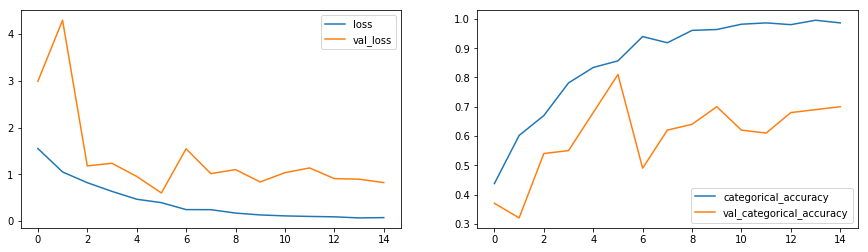

In [ ]:
plot(accuracy_check_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
Conv3D2=ModelConv3D1()
Conv3D2.initialize_src_path(main_folder)
Conv3D2.initialize_image_properties(image_height=160,image_width=160)
Conv3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
Conv3D2_model=Conv3D2.define_model(dense_neurons=256,dropout=0.5)
Conv3D2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_46 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 10, 80, 80, 32)    128       
__________

In [ ]:
print("Total Params:", Conv3D2_model.count_params())
accuracy_check_model2=Conv3D2.train_model(Conv3D2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 141s 4s/step - loss: 1.8069 - categorical_accuracy: 0.4238 - val_loss: 1.9540 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-08-1617_42_18.017403/model-00001-1.83489-0.41780-1.95398-0.50000.h5
Epoch 2/25
34/34 [==============================] - 122s 4s/step - loss: 1.4144 - categorical_accuracy: 0.5155 - val_loss: 1.1473 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-08-1617_42_18.017403/model-00002-1.36471-0.52413-1.14731-0.66000.h5
Epoch 3/25
34/34 [==============================] - 130s 4s/step - loss: 1.2399 - categorical_accuracy: 0.5710 - val_loss: 1.6087 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-08-1617_42_18.017403/model-00003-1.18566-0.57692-1.60868-0.57000.h5
Epoch 4/25
34/34 [==============================] - 127s 4s/step - loss: 1.1306 - categorical_accuracy: 0.6056 - val_loss: 1.4984 - val_categ

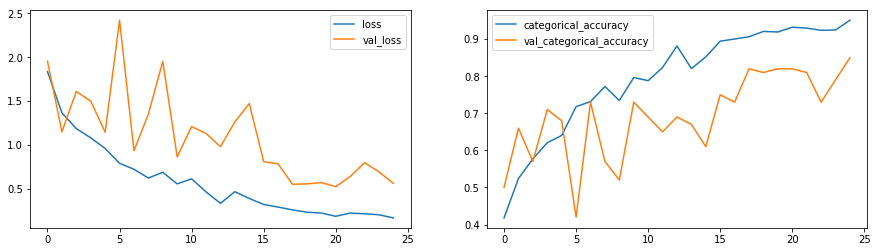

In [ ]:
plot(accuracy_check_model2)

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 91%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [ ]:
class ModelConv3D3(BuildModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D3=ModelConv3D3()
Conv3D3.initialize_src_path(main_folder)
Conv3D3.initialize_image_properties(image_height=120,image_width=120)
Conv3D3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
Conv3D3_model=Conv3D3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
Conv3D3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_49 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_50 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 8, 60, 60, 32)     128       
__________

In [ ]:
print("Total Params:", Conv3D3_model.count_params())
accuracy_check_model3=Conv3D3.train_model(Conv3D3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 96s 4s/step - loss: 2.1788 - categorical_accuracy: 0.3200 - val_loss: 1.3590 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-08-1618_41_23.634089/model-00001-2.21701-0.31297-1.35900-0.52000.h5
Epoch 2/30
23/23 [==============================] - 77s 3s/step - loss: 1.5549 - categorical_accuracy: 0.4712 - val_loss: 1.2507 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-08-1618_41_23.634089/model-00002-1.52271-0.47662-1.25067-0.57000.h5
Epoch 3/30
23/23 [==============================] - 86s 4s/step - loss: 1.4844 - categorical_accuracy: 0.5250 - val_loss: 0.9676 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-08-1618_41_23.634089/model-00003-1.39894-0.53243-0.96760-0.69000.h5
Epoch 4/30
23/23 [==============================] - 85s 4s/step - loss: 1.2263 - categorical_accuracy: 0.5591 - val_loss: 0.7995 - val_categoric

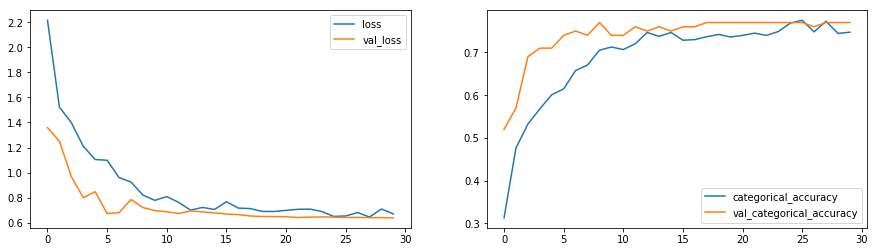

In [ ]:
plot(accuracy_check_model3)

##### Model has a  best validation accuracy of 84% and training accuracy of 84% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [ ]:
class ModelConv3D4(BuildModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D4=ModelConv3D4()
Conv3D4.initialize_src_path(main_folder)
Conv3D4.initialize_image_properties(image_height=120,image_width=120)
Conv3D4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
Conv3D4_model=Conv3D4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
Conv3D4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [ ]:
print("Total Params:", Conv3D4_model.count_params())
accuracy_check_model4=Conv3D4.train_model(Conv3D4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 192s 6s/step - loss: 2.0719 - categorical_accuracy: 0.3484 - val_loss: 8.1044 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-08-1619_51_20.422372/model-00001-2.05620-0.35294-8.10441-0.29000.h5
Epoch 2/30
34/34 [==============================] - 95s 3s/step - loss: 1.5774 - categorical_accuracy: 0.4544 - val_loss: 8.3837 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2020-08-1619_51_20.422372/model-00002-1.55828-0.46154-8.38365-0.29000.h5
Epoch 3/30
34/34 [==============================] - 98s 3s/step - loss: 1.5173 - categorical_accuracy: 0.4890 - val_loss: 4.4569 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2020-08-1619_51_20.422372/model-00003-1.45938-0.49698-4.45692-0.33000.h5
Epoch 4/30
34/34 [==============================] - 98s 3s/step - loss: 1.2800 - categorical_accuracy: 0.5346 - val_loss: 3.0993 - val_categori

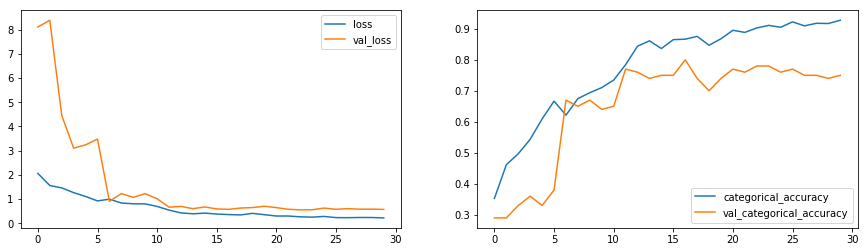

In [ ]:
plot(accuracy_check_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(BuildModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D5=ModelConv3D5()
Conv3D5.initialize_src_path(main_folder)
Conv3D5.initialize_image_properties(image_height=120,image_width=120)
Conv3D5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
Conv3D5_model=Conv3D5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
Conv3D5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_10 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [ ]:
print("Total Params:", Conv3D5_model.count_params())
accuracy_check_model5=Conv3D5.train_model(Conv3D5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 104s 3s/step - loss: 0.3333 - categorical_accuracy: 0.8837 - val_loss: 0.8438 - val_categorical_accuracy: 0.7400

Epoch 00001: saving model to model_init_2020-08-1621_36_06.356783/model-00001-0.30100-0.88914-0.84377-0.74000.h5
Epoch 2/22
34/34 [==============================] - 98s 3s/step - loss: 0.4188 - categorical_accuracy: 0.8598 - val_loss: 0.8340 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to model_init_2020-08-1621_36_06.356783/model-00002-0.35294-0.87707-0.83397-0.72000.h5
Epoch 3/22
34/34 [==============================] - 98s 3s/step - loss: 0.3814 - categorical_accuracy: 0.8602 - val_loss: 0.8299 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2020-08-1621_36_06.356783/model-00003-0.34761-0.86501-0.82986-0.72000.h5
Epoch 4/22
34/34 [==============================] - 99s 3s/step - loss: 0.3625 - categorical_accuracy: 0.8808 - val_loss: 0.8321 - val_categori

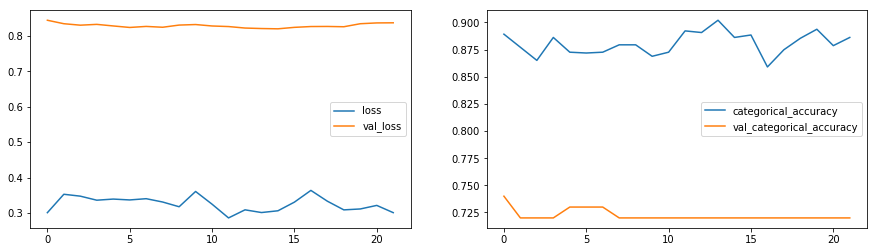

In [ ]:
plot(accuracy_check_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [ ]:
class ModelConv3D6(BuildModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D6=ModelConv3D6()
Conv3D6.initialize_src_path(main_folder)
Conv3D6.initialize_image_properties(image_height=100,image_width=100)
Conv3D6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
Conv3D6_model=Conv3D6.define_model(dense_neurons=128,dropout=0.25)
Conv3D6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 50, 50, 32)     128       
__________

In [ ]:
print("Total Params:", Conv3D6_model.count_params())
accuracy_check_model6=Conv3D6.train_model(Conv3D6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 89s 3s/step - loss: 1.7812 - categorical_accuracy: 0.3591 - val_loss: 1.3399 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-08-1622_15_00.365129/model-00001-1.80233-0.35143-1.33991-0.50000.h5
Epoch 2/30
34/34 [==============================] - 79s 2s/step - loss: 1.2679 - categorical_accuracy: 0.5335 - val_loss: 1.0280 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2020-08-1622_15_00.365129/model-00002-1.28985-0.52187-1.02801-0.62000.h5
Epoch 3/30
34/34 [==============================] - 83s 2s/step - loss: 1.0819 - categorical_accuracy: 0.6001 - val_loss: 0.9774 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-08-1622_15_00.365129/model-00003-1.05863-0.60256-0.97742-0.60000.h5
Epoch 4/30
34/34 [==============================] - 82s 2s/step - loss: 0.9486 - categorical_accuracy: 0.6233 - val_loss: 0.9128 - val_categorica

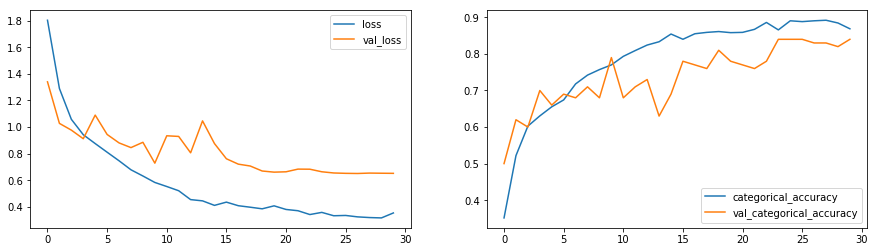

In [ ]:
plot(accuracy_check_model6)

###### For the above  model the best validation accuracy is 84%

# Model 7 - CNN- LSTM Model

In [ ]:
class CNNRNN1(BuildModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
cnn_rnn1=CNNRNN1()
cnn_rnn1.initialize_src_path(main_folder)
cnn_rnn1.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_rnn1_model=cnn_rnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_rnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [ ]:
print("Total Params:", cnn_rnn1_model.count_params())
accuracy_check_model7=cnn_rnn1.train_model(cnn_rnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 190s 6s/step - loss: 1.3851 - categorical_accuracy: 0.4003 - val_loss: 1.2254 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-08-1706_26_13.859990/model-00001-1.38676-0.39367-1.22537-0.51000.h5
Epoch 2/20
34/34 [==============================] - 98s 3s/step - loss: 1.0953 - categorical_accuracy: 0.5460 - val_loss: 0.9736 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-08-1706_26_13.859990/model-00002-1.08392-0.55128-0.97363-0.58000.h5
Epoch 3/20
34/34 [==============================] - 98s 3s/step - loss: 0.9323 - categorical_accuracy: 0.6240 - val_loss: 0.8850 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-08-1706_26_13.859990/model-00003-0.94717-0.61463-0.88499-0.61000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.8149 - categorical_accuracy: 0.6707 - val_loss: 0.9840 - val_categor

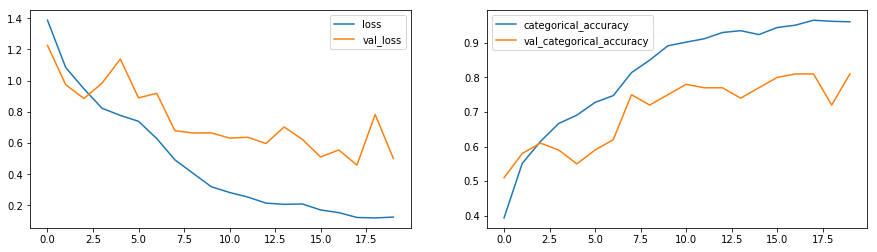

In [ ]:
plot(accuracy_check_model7)

##### For CNN - LSTM model we get a perfect validation accuracy of 81%

# Augmentation Process

In [ ]:
class BuildModelMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_src_path(self,main_folder):
        self.train_doc = np.random.permutation(open(main_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(main_folder + '/' + 'val.csv').readlines())
        self.train_path = main_folder + '/' + 'train'
        self.val_path =  main_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                  
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model 8 - (3,3,3) Filter & 160x160 Image resolution

In [ ]:
class ModelConv3D8(BuildModelMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D8=ModelConv3D8()
Conv3D8.initialize_src_path(main_folder)
Conv3D8.initialize_image_properties(image_height=160,image_width=160)
Conv3D8.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
Conv3D8_model=Conv3D8.define_model(dense_neurons=256,dropout=0.5)
Conv3D8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 80, 80, 32)    128       
__________

In [ ]:
print("Total Params:", Conv3D8_model.count_params())
accuracy_check_model8=Conv3D8.train_model(Conv3D8_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 141s 4s/step - loss: 0.4433 - categorical_accuracy: 0.8311 - val_loss: 0.5234 - val_categorical_accuracy: 0.8200

Epoch 00001: saving model to model_init_2020-08-1708_52_44.883497/model-00001-0.44235-0.83107-0.52339-0.82000.h5
Epoch 2/30
34/34 [==============================] - 136s 4s/step - loss: 0.4365 - categorical_accuracy: 0.8355 - val_loss: 0.5248 - val_categorical_accuracy: 0.8200

Epoch 00002: saving model to model_init_2020-08-1708_52_44.883497/model-00002-0.43716-0.83560-0.52485-0.82000.h5
Epoch 3/30
34/34 [==============================] - 135s 4s/step - loss: 0.3902 - categorical_accuracy: 0.8473 - val_loss: 0.5195 - val_categorical_accuracy: 0.8300

Epoch 00003: saving model to model_init_2020-08-1708_52_44.883497/model-00003-0.38787-0.84766-0.51952-0.83000.h5
Epoch 4/30
34/34 [==============================] - 136s 4s/step - loss: 0.4420 - categorical_accuracy: 0.8389 - val_loss: 0.5205 - val_categ

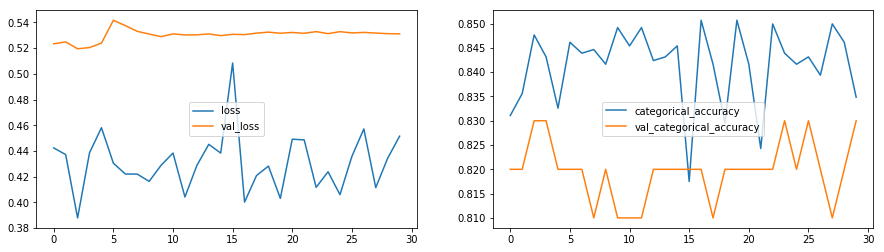

In [ ]:
plot(accuracy_check_model8)

# Model 9 - (2,2,2) Filter  & 120x120 Image resolution

In [ ]:
class ModelConv3D9(BuildModelMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D9=ModelConv3D9()
Conv3D9.initialize_src_path(main_folder)
Conv3D9.initialize_image_properties(image_height=120,image_width=120)
Conv3D9.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
Conv3D9_model=Conv3D9.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
Conv3D9_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [ ]:
print("Total Params:", Conv3D9_model.count_params())
accuracy_check_model9=Conv3D9.train_model(Conv3D9_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 182s 8s/step - loss: 2.1596 - categorical_accuracy: 0.3227 - val_loss: 1.2268 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-08-1711_09_30.277294/model-00001-2.17344-0.32881-1.22680-0.54000.h5
Epoch 2/30
23/23 [==============================] - 91s 4s/step - loss: 1.5971 - categorical_accuracy: 0.4587 - val_loss: 0.9871 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2020-08-1711_09_30.277294/model-00002-1.50682-0.47662-0.98709-0.62000.h5
Epoch 3/30
23/23 [==============================] - 92s 4s/step - loss: 1.3288 - categorical_accuracy: 0.5303 - val_loss: 0.8356 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-08-1711_09_30.277294/model-00003-1.28435-0.54449-0.83558-0.63000.h5
Epoch 4/30
23/23 [==============================] - 91s 4s/step - loss: 1.1733 - categorical_accuracy: 0.5685 - val_loss: 0.7399 - val_categori

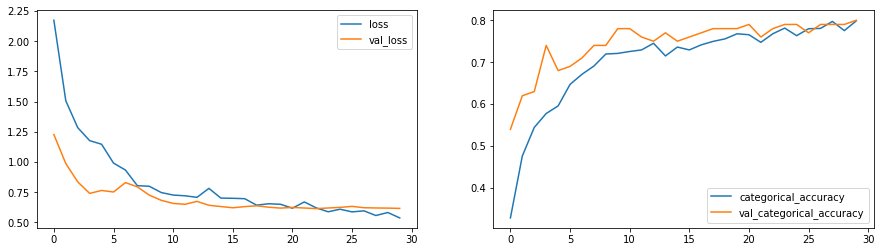

In [ ]:
plot(accuracy_check_model9)

# Model 10 - Adding more layers

In [ ]:
class ModelConv3D10(BuildModelMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D10=ModelConv3D10()
Conv3D10.initialize_src_path(main_folder)
Conv3D10.initialize_image_properties(image_height=120,image_width=120)
Conv3D10.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
Conv3D10_model=Conv3D10.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
Conv3D10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [ ]:
print("Total Params:", Conv3D10_model.count_params())
accuracy_check_model10=Conv3D10.train_model(Conv3D10_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 110s 3s/step - loss: 0.8594 - categorical_accuracy: 0.7079 - val_loss: 0.9512 - val_categorical_accuracy: 0.7200

Epoch 00001: saving model to model_init_2020-08-1712_41_20.176426/model-00001-0.87286-0.70060-0.95120-0.72000.h5
Epoch 2/30
34/34 [==============================] - 102s 3s/step - loss: 0.8131 - categorical_accuracy: 0.6917 - val_loss: 1.0764 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to model_init_2020-08-1712_41_20.176426/model-00002-0.80112-0.70060-1.07643-0.72000.h5
Epoch 3/30
34/34 [==============================] - 102s 3s/step - loss: 0.7512 - categorical_accuracy: 0.7093 - val_loss: 0.8289 - val_categorical_accuracy: 0.7600

Epoch 00003: saving model to model_init_2020-08-1712_41_20.176426/model-00003-0.74945-0.71041-0.82894-0.76000.h5
Epoch 4/30
34/34 [==============================] - 102s 3s/step - loss: 0.6746 - categorical_accuracy: 0.7524 - val_loss: 0.8057 - val_categ

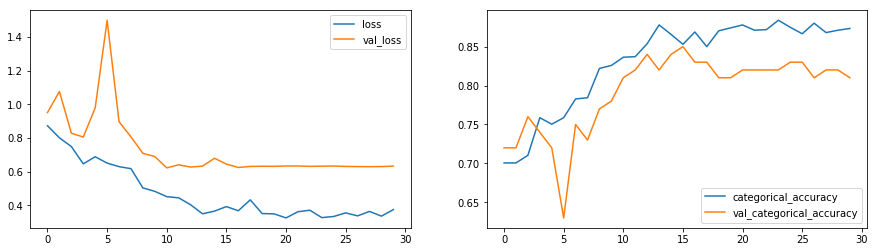

In [ ]:
plot(accuracy_check_model10)

# Model 11 - CNN LSTM with GRU

In [ ]:
class CNNRNN2(BuildModelMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
cnn_rnn2=CNNRNN2()
cnn_rnn2.initialize_src_path(main_folder)
cnn_rnn2.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_rnn2_model=cnn_rnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_rnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [ ]:
print("Total Params:", cnn_rnn2_model.count_params())
accuracy_check_model11=cnn_rnn2.train_model(cnn_rnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 162s 5s/step - loss: 1.4901 - categorical_accuracy: 0.3477 - val_loss: 1.2201 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-08-1713_35_22.716313/model-00001-1.49209-0.35219-1.22005-0.56000.h5
Epoch 2/20
34/34 [==============================] - 99s 3s/step - loss: 1.1252 - categorical_accuracy: 0.5276 - val_loss: 1.0239 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-08-1713_35_22.716313/model-00002-1.12983-0.53243-1.02391-0.60000.h5
Epoch 3/20
34/34 [==============================] - 100s 3s/step - loss: 0.9085 - categorical_accuracy: 0.6391 - val_loss: 0.9902 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-08-1713_35_22.716313/model-00003-0.90659-0.64253-0.99023-0.60000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.7908 - categorical_accuracy: 0.6957 - val_loss: 0.8379 - val_catego

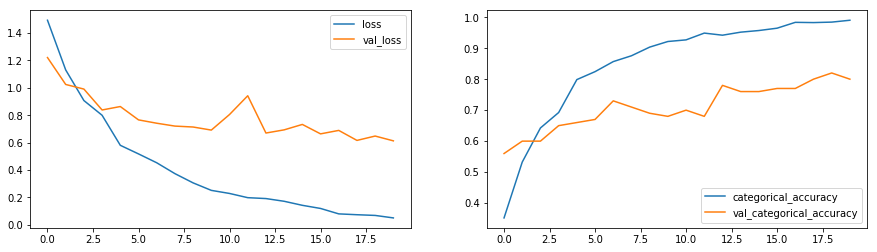

In [ ]:
plot(accuracy_check_model11)

### Completely overfitting